# Reinforcement Learning: Control Problems

In [346]:
%matplotlib inline

In [347]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import namedtuple, deque
torch.manual_seed(0)

This notebook will focus on solving a class of RL problems known as control problems. 

## Environment

RL learns optimal sequential decision-making through interaction with an environment. 

We will use the [Cart Pole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) environment from OpenAI's Gym library. In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The goal is to keep the pole upright for as long as possible, so a reward of +1 for every step taken, including the termination step, is alloted. 

The episode ends if any one of the following occurs:
1. Termination: Pole Angle is greater than ±12°
2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3. Truncation: Episode length is greater than 500

We begin by initializing the environment. 

In [348]:
env = gym.make('CartPole-v1')


The observation space is an array with shape $(4,)$ with the values:
1. Cart position (min:$-4.8$, max:$4.8$)
2. Cart velocity (min:$-\inf$, max:$\inf$)
3. Pole angle (min:$\sim -0.418 \text{rad} (-24^\circ)$, max:$\sim 0.418 \text{rad} (-24^\circ)$)
4. Pole angular velocity (min:$-\inf$, max:$\inf$)


Initial state: All observations are assigned a uniformly random value in `(-0.05, 0.05)`

In [349]:
state_size = env.observation_space.shape[0]
state_size

4

In [350]:
env.reset()

(array([-0.00788696,  0.02057347, -0.0285085 ,  0.00262838], dtype=float32),
 {})

## Action selection

The action space is $\{0, 1\}$, which corresponds to push cart to the left/right, respectively. 
We define a function that selects an action based on the current state according to the $\epsilon$-greedy policy.

In [351]:
action_size = env.action_space.n
action_size

2

In [352]:
def select_action(q_net, state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    else:
        with torch.no_grad():
            q_values = q_net(torch.FloatTensor(state))
            return int(torch.argmax(q_values))

## Networks

The Q-network is modeled as a simple linear neural network, which takes in the state and outputs two numbers; the value of performing each of the two actions, respectively, in that state. 

In [353]:
class QNetwork(nn.Module):
    def __init__(self, input_size=state_size, hidden_size=2**7, output_size=action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

## DQN

[Deep Q-Network (DQN)](https://arxiv.org/pdf/1312.5602.pdf) is a value-based RL algorithm which is based on combining deep learning with the traditional Q-learning algorithm. 

### Replay memory

One of the clever innovations of DQN was the use of replay memory to ensure more diverse gradient sampels when updating the neural network. 

In reinforcement learning, the tuple $(S, A, R, S')$ is known as a transition. In our case we also add a final elemen $D$ which indicates if the state was terminal or not. 

In [354]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

A replay memory stores a bunch of these transitions.

In [355]:
class ReplayMemory(object):
    def __init__(self, capacity: int) -> None:
        self.memory = deque([],maxlen=capacity)

    def push(self, *args) -> None:
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        return len(self.memory)

And the agent randomly samples transitions from the replay memory when updating the policy, which aids in updating the neural network by doing it on different types of experiences. 

In [356]:
def get_batch(replay_buffer: ReplayMemory, batch_size: int):
    if len(replay_buffer) < batch_size:
        return
    if batch_size < 2:
        raise ValueError("Argument batch_size must be integer >= 2")
    
    batch = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*batch))
    return batch.state, batch.action, batch.reward, batch.next_state, batch.done

### Target network

Another innovation of DQN is the use of target networks to implement periodic updates to the Q-networks to stabilize learning and avoiding the problem of chasing moving targets.  

We use the soft update method of gradually copying the weight over to the target network. 

In [357]:
def soft_updates(net: torch.nn.Module, target_net: torch.nn.Module, tau=0.1):
    """ Ø' <- tØ' + (1-t)Ø """
    with torch.no_grad():
        for p, p_targ in zip(net.parameters(), target_net.parameters()):
            p_targ.data.mul_(tau)
            p_targ.data.add_((1 - tau) * p.data)

### Training loop

Return critic loss $(Q(s_t, a_t) - (\gamma  Q(s_{t+1}, a') + R))^2 / N$ for $t = 0,1,...,N$ for all $N$ elements in the batch. 

In [358]:
def get_loss(batch: tuple, net: torch.nn.Module, target_net: torch.nn.Module, gamma: int) -> torch.Tensor: 
    states, actions, rewards, next_states, dones = batch

    # Convert to PyTorch tensors
    states = torch.tensor(np.array(states)).float()
    actions = torch.tensor(actions)
    rewards = torch.tensor(rewards).float()
    next_states = torch.tensor(next_states).float()
    dones = torch.tensor(dones)

    # Compute Q values
    current_q_values = net(states).gather(1, actions.unsqueeze(1))
    next_q_values = target_net(next_states).max(dim=1)[0].detach()

    # Compute targets
    targets = rewards + gamma * next_q_values * (1 - dones.float())
    targets = targets.unsqueeze(1)

    # Use Mean Squared Error loss
    return nn.MSELoss()(current_q_values, targets)


Get a batch, get the loss and perform a gradient ascent step. 

In [359]:
def update(replay_buffer: ReplayMemory, batch_size: int, net: torch.nn.Module, target_net: torch.nn.Module, optimizer: torch.optim, gamma: int) -> None:
    batch = get_batch(replay_buffer, batch_size)
    if batch is None:
        return

    loss = get_loss(batch, net, target_net, gamma)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 1) ###
    optimizer.step()

The DQN training algorithm involves looping over a desired number of training episodes, and for each episode we:
* Repeat until the episode is finished:
    1. select action based on the state we are in (initial state for first action)
    2. perform action in environment, and get the next state, reward, and a boolean flag that signifies if the episode is finished
    3. update the Q-network
    4. update the target-network


In [389]:
def train_dqn(q_network, target_network, optimizer, scheduler, replay_buffer, num_episodes=1000, batch_size=32, gamma=0.99, epsilon_decay=0.995, min_epsilon=0.01):
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        epsilon = max(min_epsilon, epsilon_decay ** episode)
        done = False

        while not done:
            action = select_action(q_network, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)

            replay_buffer.push(state, action, reward, next_state, done)
            update(replay_memory, batch_size, q_network, target_network, optimizer, gamma)
            soft_updates(q_network, target_network)

            state = next_state
            total_reward += reward
        
        scheduler.step()
        rewards.append(total_reward)

    return rewards

Now we 
* Initialize the Q-network
* Initialize the target-network, and copy the weights from the q-network
* Initialize the optimizer
* Initialize the scheduler
* Initialize the replay memory
* Run the training loop

In [394]:
hidden_size = 2**8
q_network = QNetwork(state_size, hidden_size, action_size)

target_network = QNetwork(state_size, hidden_size, action_size)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=1e-3)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

replay_memory_size = 10**4
replay_memory = ReplayMemory(replay_memory_size)

rewards = train_dqn(q_network, target_network, optimizer, scheduler, replay_memory, 
          num_episodes=500, 
          batch_size=2**7, 
          gamma=1-1e-2, 
          epsilon_decay=1-1e-2,
          min_epsilon=1e-6,
          )

Finally we plot the (smoothed) rewards

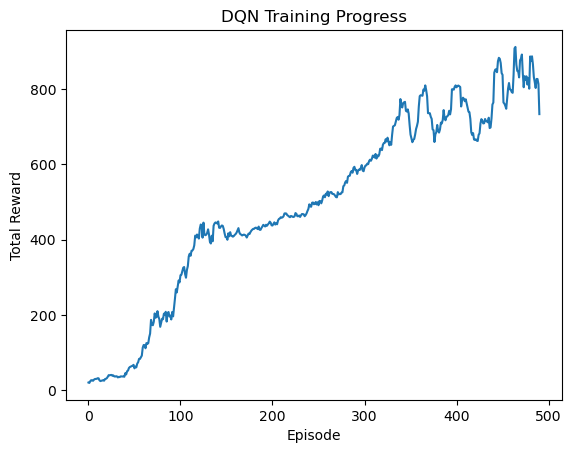

In [395]:
# Plotting rewards
window_size=10
smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.show()